In [1]:
#NOTE: Trained on the filtered CGM data
#NOTE: Add values and lags for CGM gradient

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Glucose_processor import GlucoseDataProcessor
from models.model_F import BloodGlucosePredictorF

In [2]:
# Define prediction horizons (in minutes, adjust as needed)
horizons = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]

# Initialize the BloodGlucosePredictor
bg_predictor = BloodGlucosePredictorF(horizons=horizons)

In [3]:
Glucose_data = GlucoseDataProcessor(CGM_file_path="CGM_data.csv", bolus_file_path="Bolus_data.csv", carb_file_path="Carb_data.csv",
                                    min_range=69, max_range=180, target=85, tp=75, td=280, dp=45, dd=180)


df = Glucose_data.create_filtered_DataFrame()

df

Time         CGM  CGM Gradient  Insulin Activity  \
3255  2024-12-09 01:57:16   74.633941     -0.475844          0.000000   
3254  2024-12-09 02:02:16   77.013161     -0.526178          0.000000   
3253  2024-12-09 02:07:16   79.895722     -0.634878          0.000000   
3252  2024-12-09 02:12:16   83.361943     -0.759700          0.000000   
3251  2024-12-09 02:17:16   87.477852     -0.892044          0.000000   
...                   ...         ...           ...               ...   
4     2024-12-20 13:51:28  149.673834     -0.631057          0.032914   
3     2024-12-20 13:56:27  152.754635     -0.597968          0.032283   
2     2024-12-20 14:01:27  155.653519     -0.558222          0.031558   
1     2024-12-20 14:06:27  158.336854     -0.511975          0.030786   
0     2024-12-20 14:11:27  160.773267     -0.487282          0.029946   

      Food Activity  
3255       0.000000  
3254       0.000000  
3253       0.000000  
3252       0.000000  
3251       0.000000  
...             ...  
4          0.130190  
3          0.123480  
2          0.116350  
1          0.108902  
0          0.101206  

[3256 rows x 5 columns]

In [4]:
# Preprocess the data
X_scaled, y_scaled = bg_predictor.preprocess_data(df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])  # Shape required for LSTM (timesteps=X_train.shape[1], features=X_train.shape[2])
bg_predictor.build_model(input_shape=input_shape)


d:\DiaPulse\models\model_F.py:21: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)  # Linear interpolation for missing values


In [5]:
# Train the model
model_save_path = 'saved_models/model_F.keras'
history = bg_predictor.train(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=2000,
    model_save_path=model_save_path
)

history

(2573, 10, 26)
Epoch 1/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.2956 - mae: 0.3934 - val_loss: 0.0349 - val_mae: 0.1341
Epoch 2/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0441 - mae: 0.1537 - val_loss: 0.0234 - val_mae: 0.1106
Epoch 3/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0265 - mae: 0.1184 - val_loss: 0.0154 - val_mae: 0.0887
Epoch 4/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0226 - mae: 0.1085 - val_loss: 0.0148 - val_mae: 0.0869
Epoch 5/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0207 - mae: 0.1033 - val_loss: 0.0132 - val_mae: 0.0830
Epoch 6/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0184 - mae: 0.0997 - val_loss: 0.0128 - val_mae: 0.0832
Epoch 7/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0157 - mae: 0.0921 - val_loss: 0.0116 - val_mae: 0.0779
Epoch 8/2000
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0149 - mae: 0.0900 - val_loss: 0.0114 - val_mae: 0.0786
Epoch 9/2000
65/65 ━━━━━━━━━━━━━━

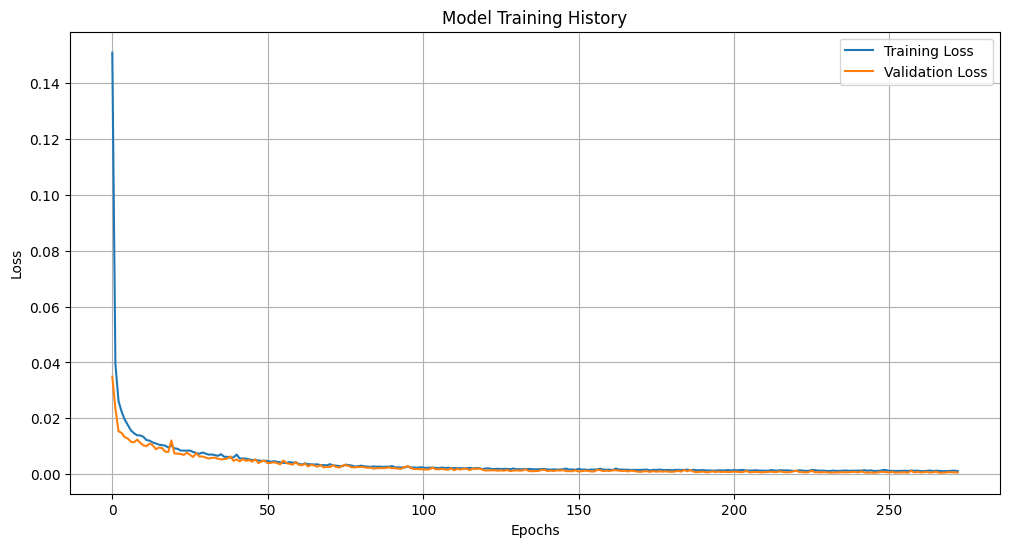

In [6]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Evaluate the model on test data
loss, mae = bg_predictor.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Test Loss: 0.0005, Test MAE: 0.0163


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


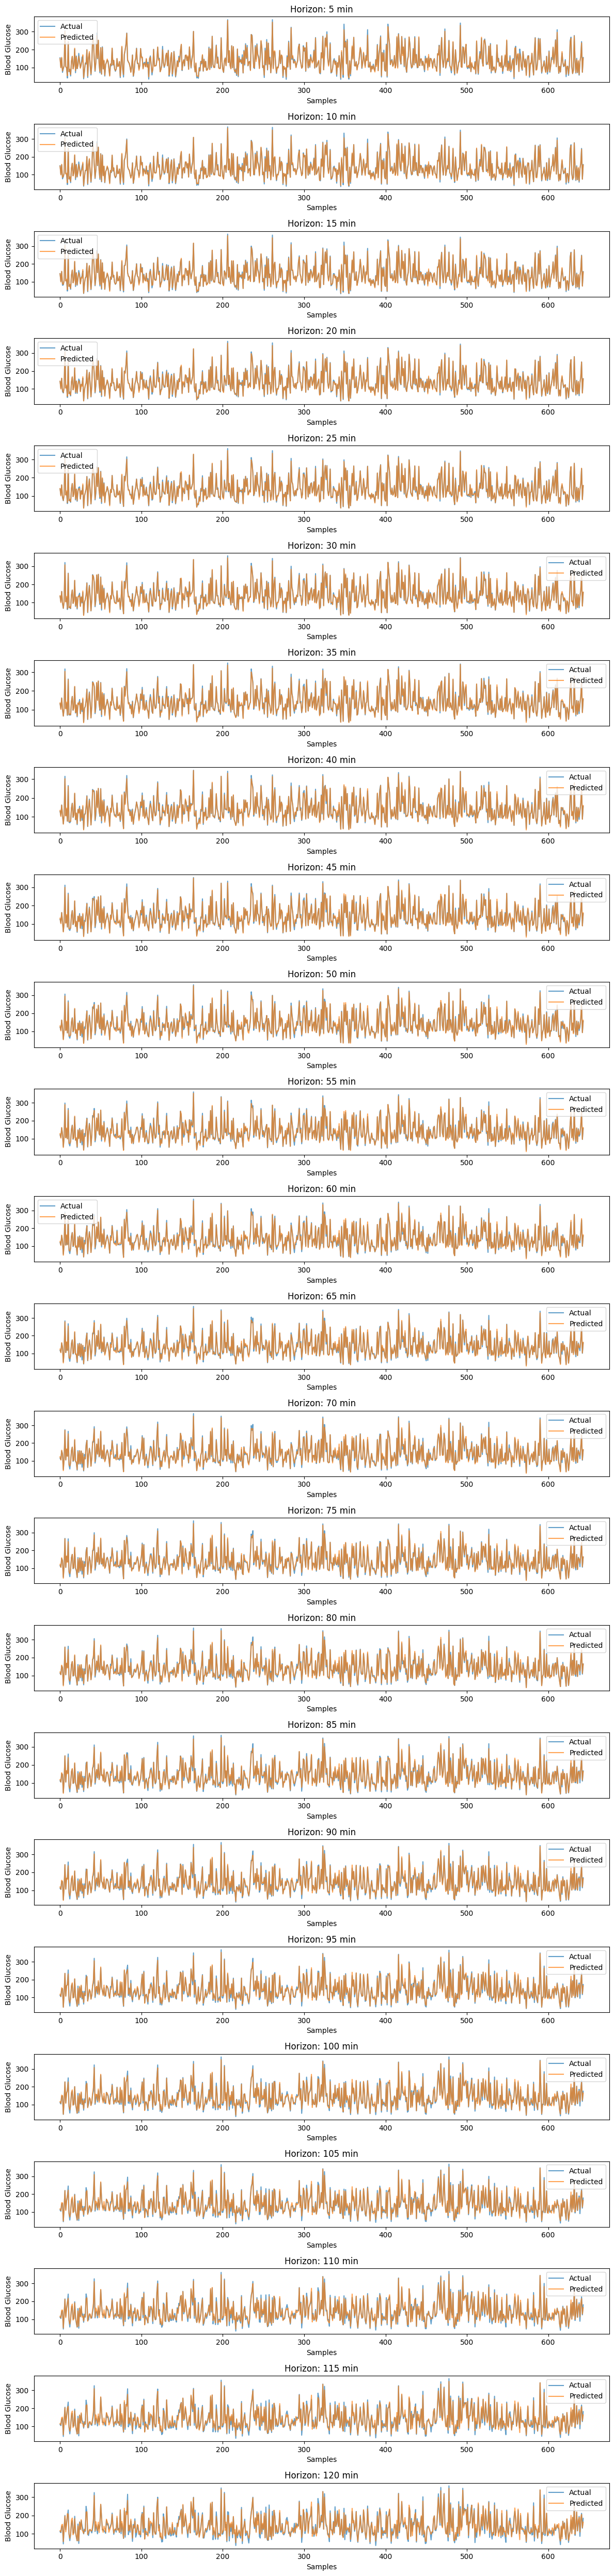

In [8]:
# Make predictions on test data
y_pred = bg_predictor.predict(X_test)

# Visualize predictions vs actual
plt.figure(figsize=(12, 50))
for i, horizon in enumerate(horizons):
    plt.subplot(len(horizons), 1, i + 1)
    plt.plot(bg_predictor.scaler_y.inverse_transform(y_test)[:, i], label='Actual', alpha=0.7)
    plt.plot(y_pred[:, i], label='Predicted', alpha=0.7)
    plt.title(f'Horizon: {horizon} min')
    plt.xlabel('Samples')
    plt.ylabel('Blood Glucose')
    plt.legend()
    plt.tight_layout()
plt.show()

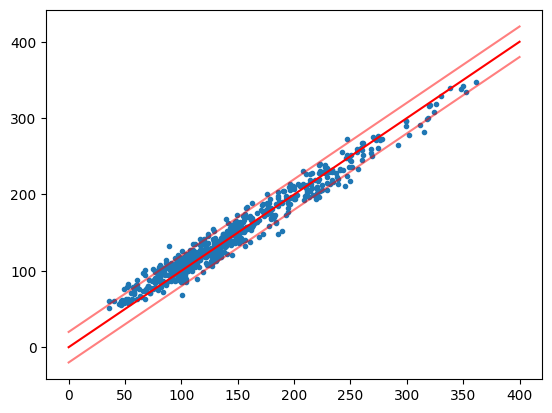

In [21]:
plt.figure()

i = 23 # Where {0: 5 min, 1: 10 min, 2: 15 min, ... 22: 120 min}

plt.plot(bg_predictor.scaler_y.inverse_transform(y_test)[:, i], y_pred[:, i], ".")

x = np.linspace(0, 400, 100)

plt.plot(x, x, "r")
plt.plot(x, x+20, "r", alpha=0.5)
plt.plot(x, x-20, "r", alpha=0.5)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


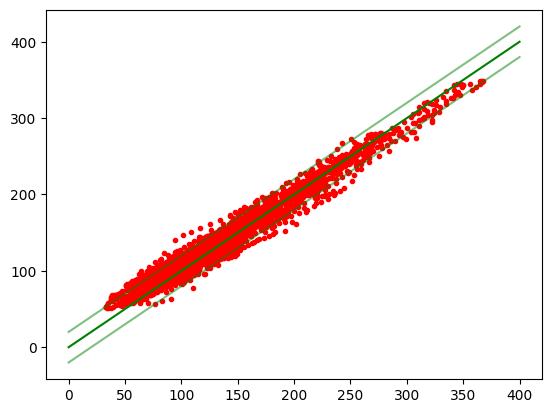

In [23]:
# Training data!!

y_train_pred = bg_predictor.predict(X_train)

plt.figure()

i = 23 # Where {0: 5 min, 1: 10 min, 2: 15 min, ... 22: 120 min}

plt.plot(bg_predictor.scaler_y.inverse_transform(y_train)[:, i], y_train_pred[:, i], ".", color="r")

x = np.linspace(0, 400, 100)

plt.plot(x, x, "g")
plt.plot(x, x+20, "g", alpha=0.5)
plt.plot(x, x-20, "g", alpha=0.5)

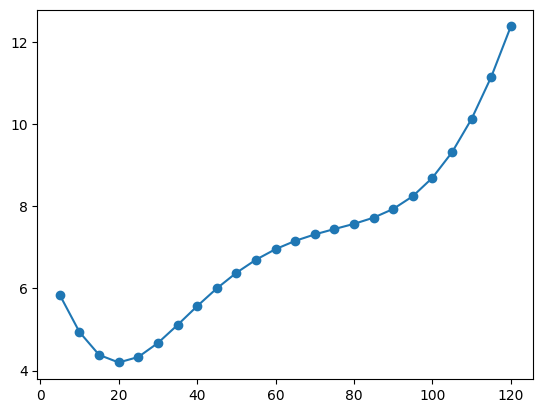

In [11]:
# Find RMSE of every horizon

from sklearn.metrics import mean_squared_error

rmse = []

for i, horizon in enumerate(horizons):
    actual = bg_predictor.scaler_y.inverse_transform(y_test)[:, i]
    pred = y_pred[:, i]
    rmse.append(np.sqrt(mean_squared_error(actual, pred)))


plt.plot(horizons, rmse, "o-")

horizons       MAE
0          5  2.055228
1         10  1.917023
2         15  1.833618
3         20  1.804281
4         25  1.830535
5         30  1.901194
6         35  1.977604
7         40  2.054154
8         45  2.122859
9         50  2.178387
10        55  2.231246
11        60  2.276813
12        65  2.312925
13        70  2.340138
14        75  2.360388
15        80  2.389390
16        85  2.432929
17        90  2.484533
18        95  2.540311
19       100  2.615568
20       105  2.724456
21       110  2.847037
22       115  2.977271
23       120  3.128643

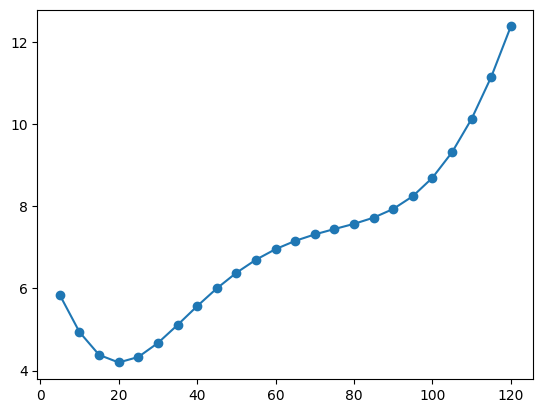

In [12]:
# Find MAE of every horizon

from sklearn.metrics import mean_absolute_error

mae = []

for i, horizon in enumerate(horizons):
    actual = bg_predictor.scaler_y.inverse_transform(y_test)[:, i]
    pred = y_pred[:, i]
    mae.append(np.sqrt(mean_absolute_error(actual, pred)))


plt.plot(horizons, rmse, "o-")

df = pd.DataFrame({"horizons": horizons, "MAE": mae})
df

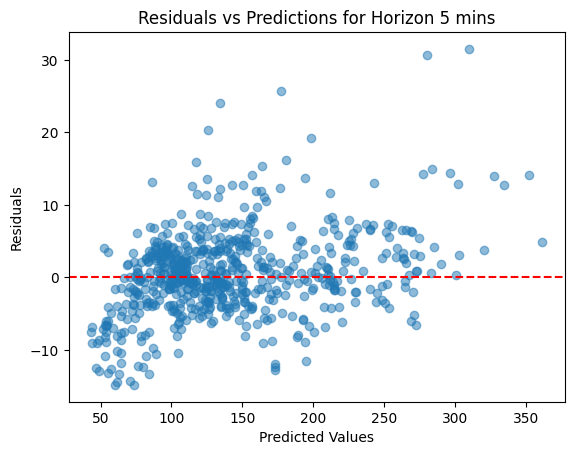

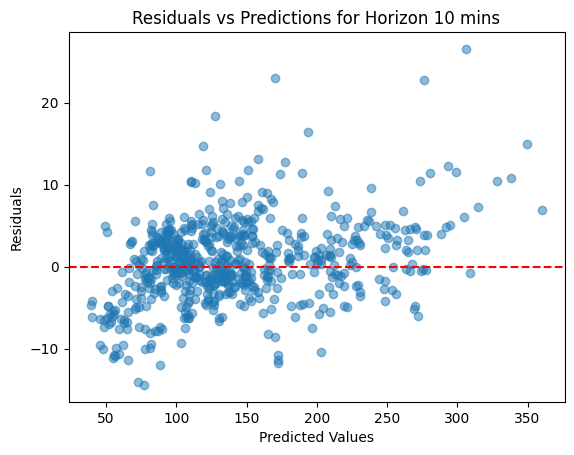

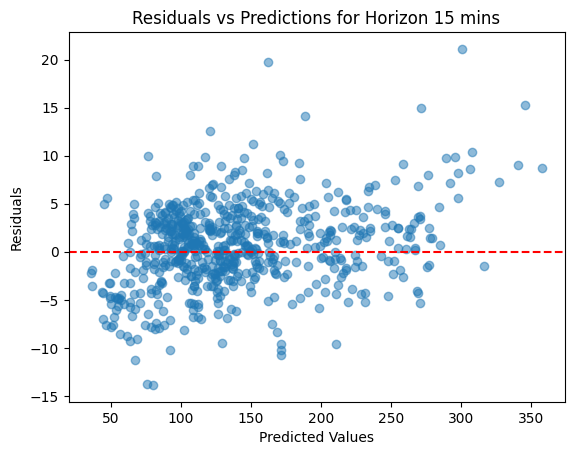

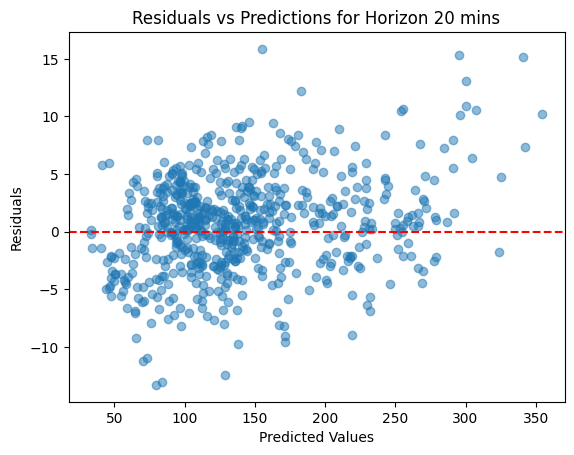

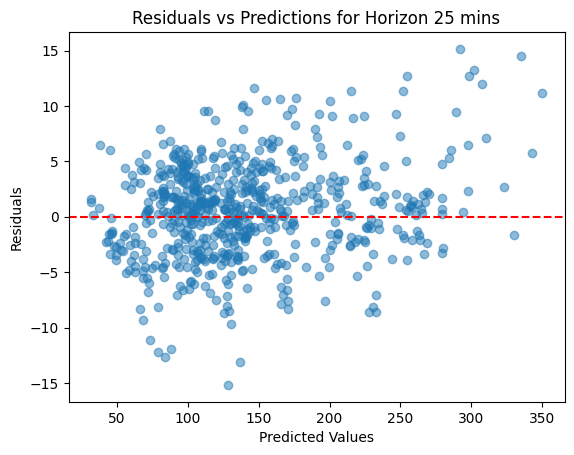

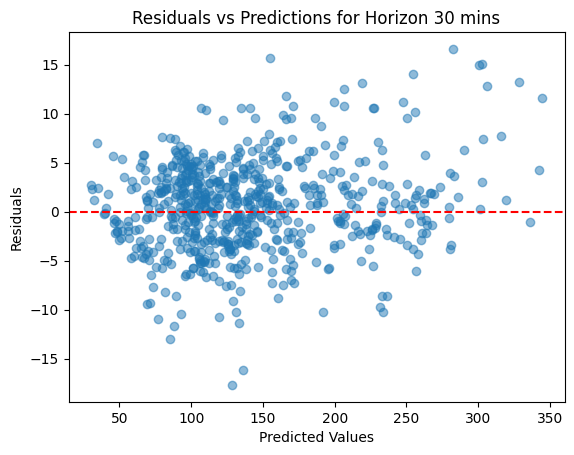

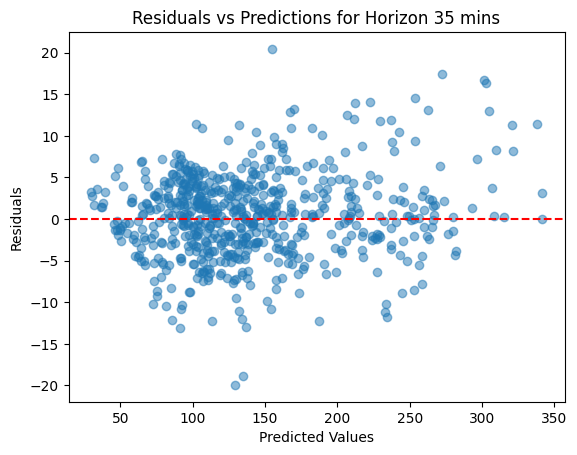

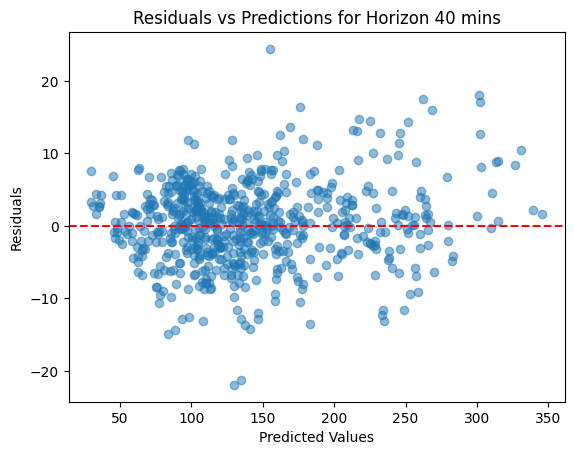

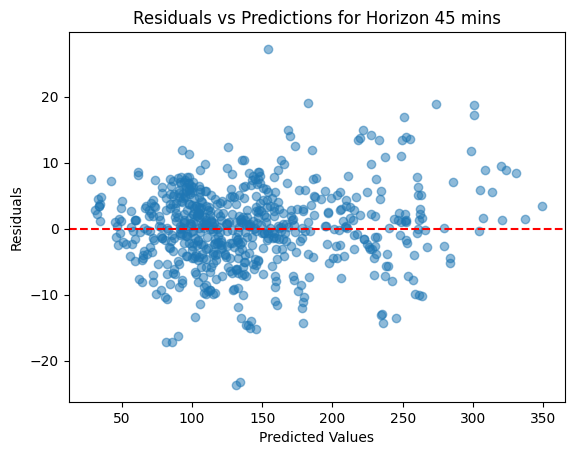

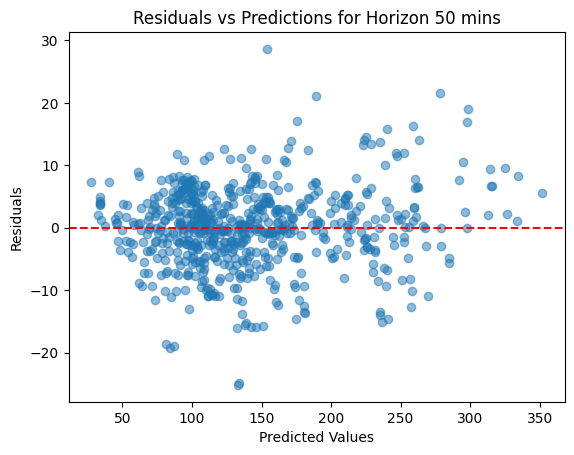

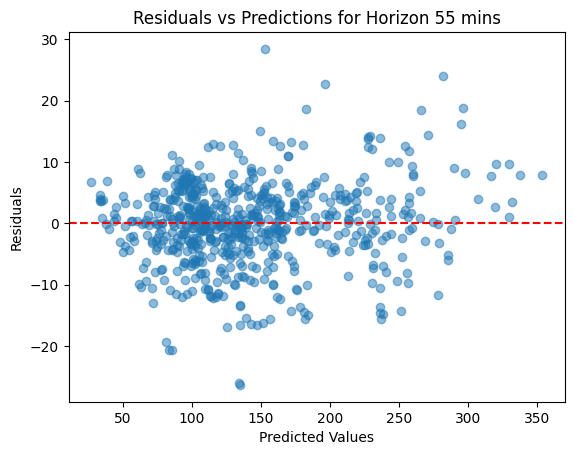

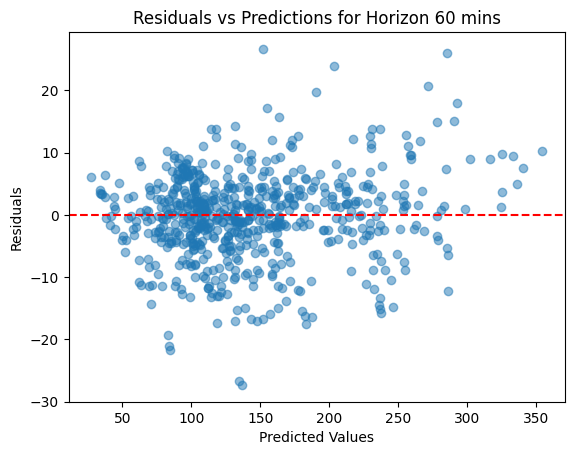

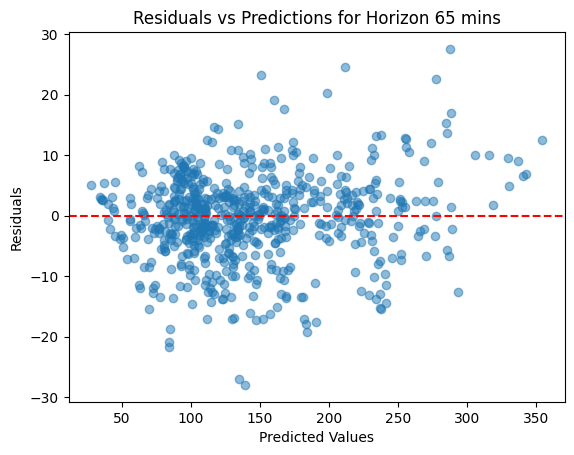

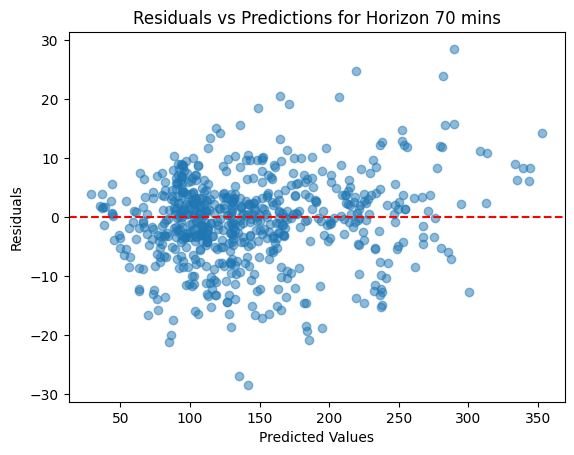

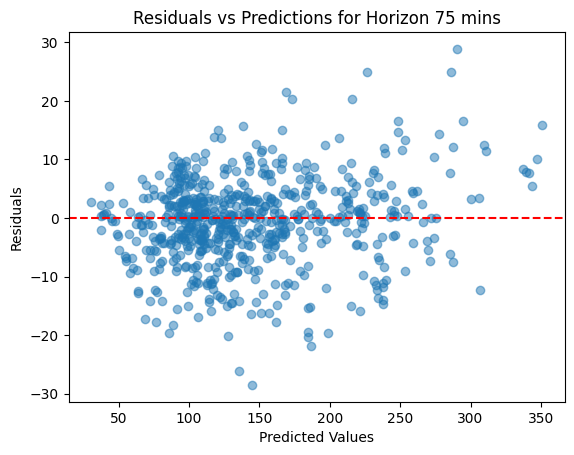

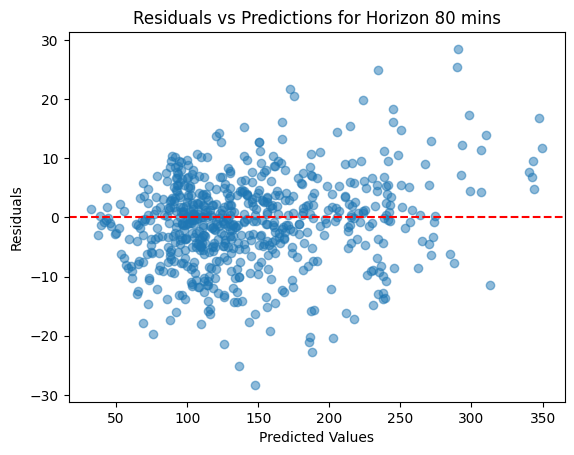

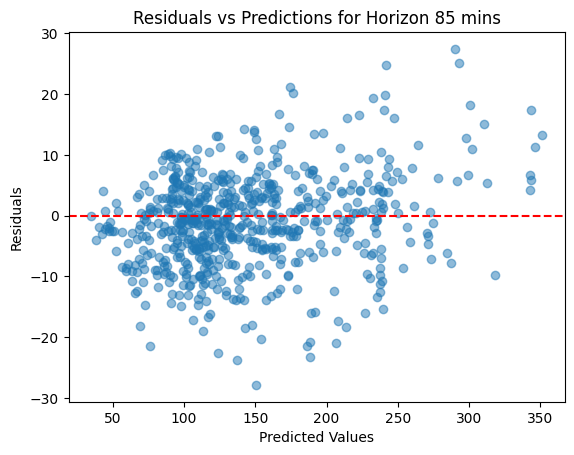

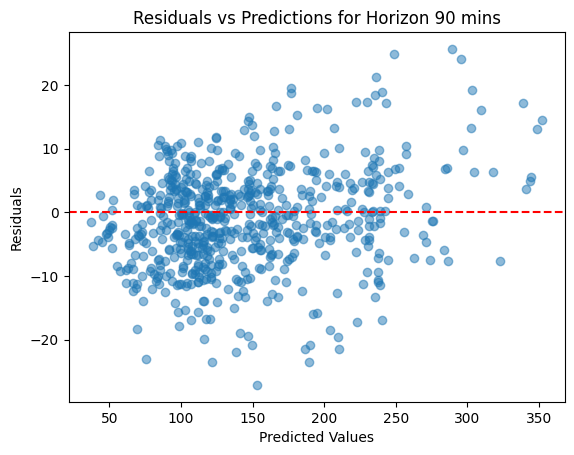

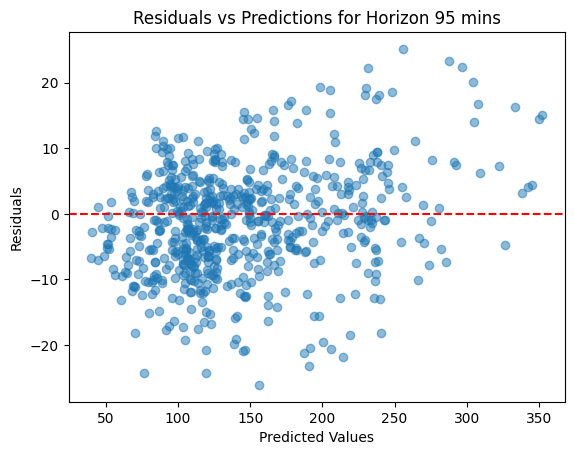

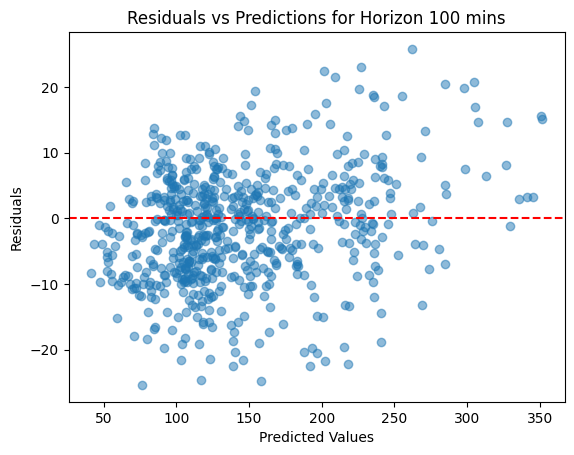

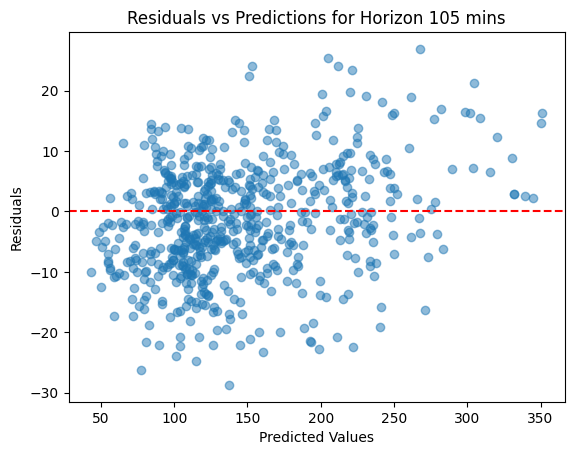

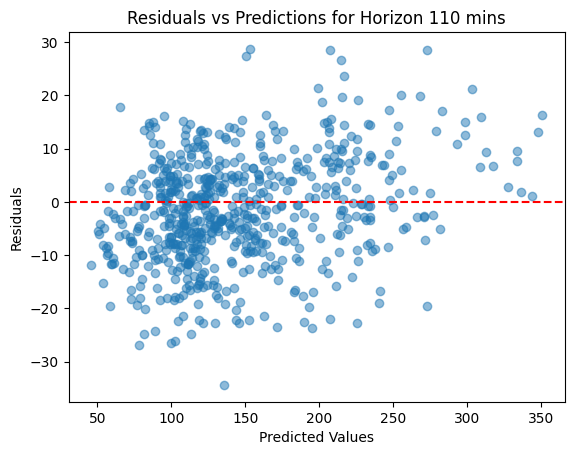

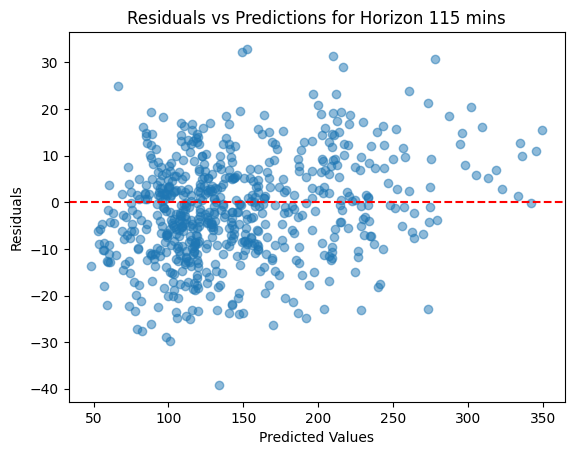

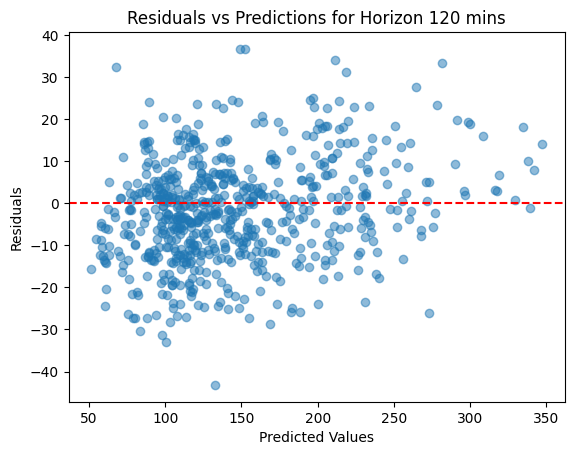

In [13]:
# Residuals

residuals_per_horizon = {f"Horizon_{h}": bg_predictor.scaler_y.inverse_transform(y_test)[:, i] - y_pred[:, i] for i, h in enumerate(horizons)}

for i, h in enumerate(horizons):
    plt.figure()
    plt.scatter(y_pred[:, i], residuals_per_horizon[f"Horizon_{h}"], alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs Predictions for Horizon {h} mins')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()



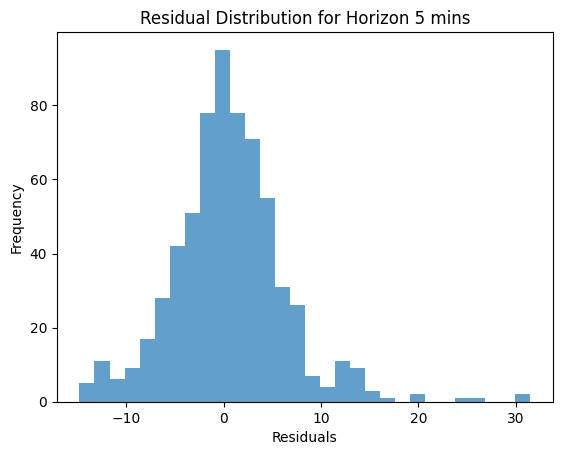

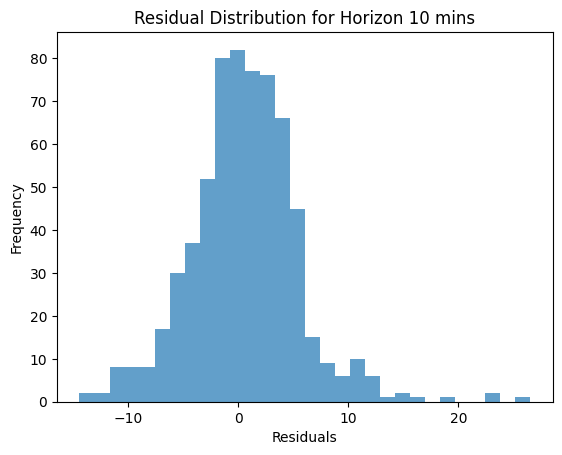

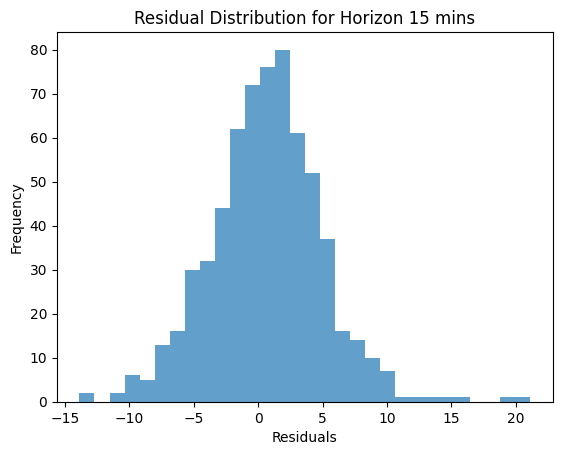

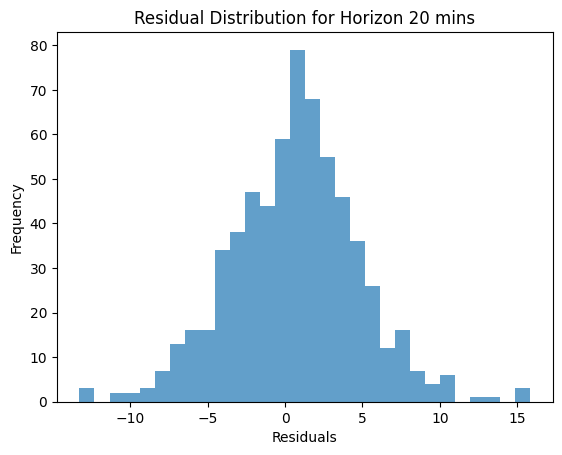

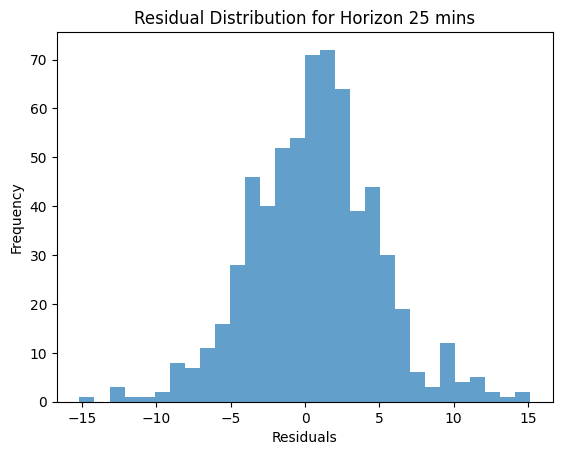

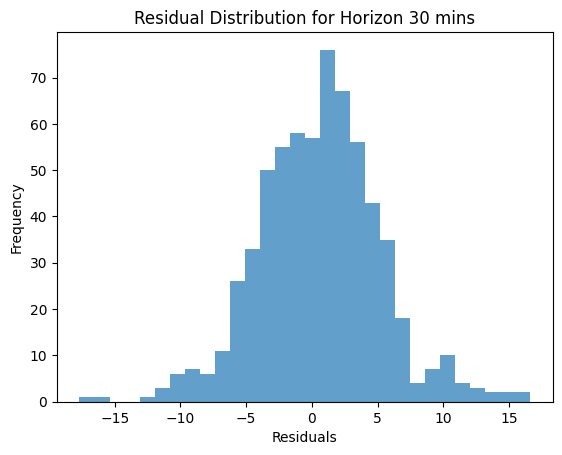

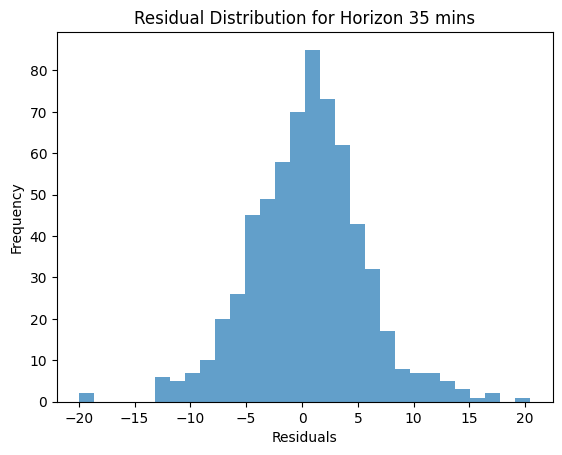

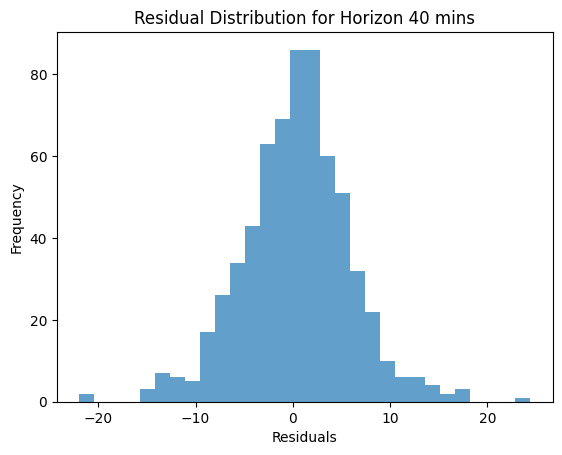

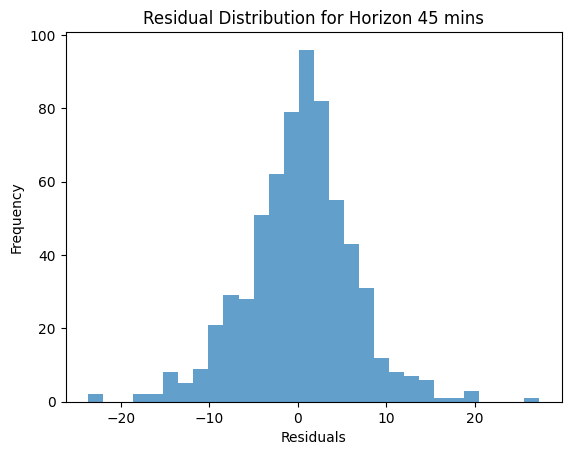

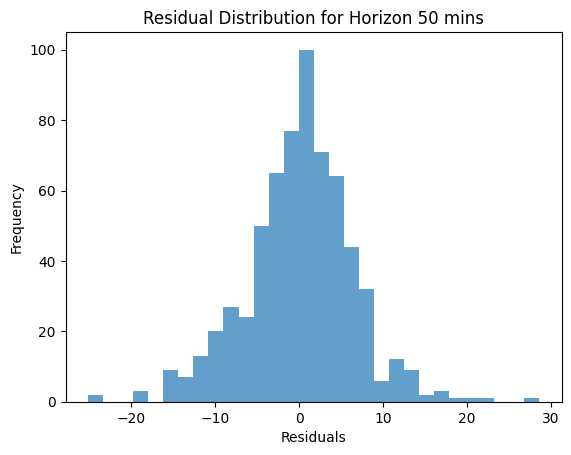

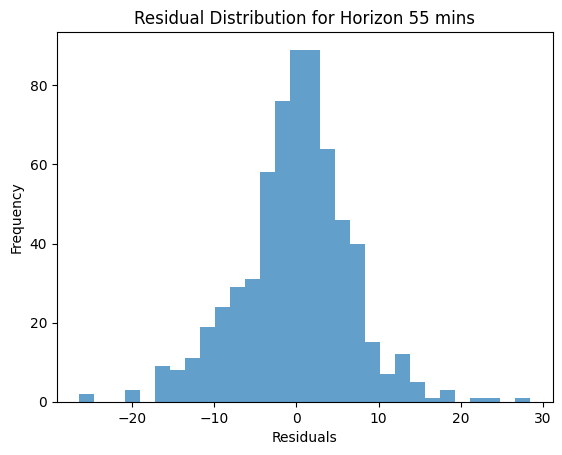

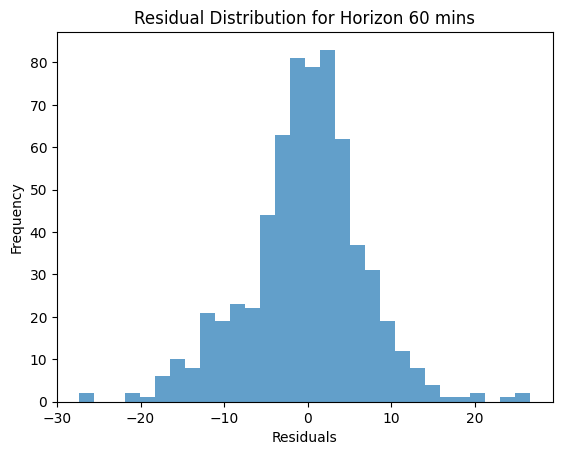

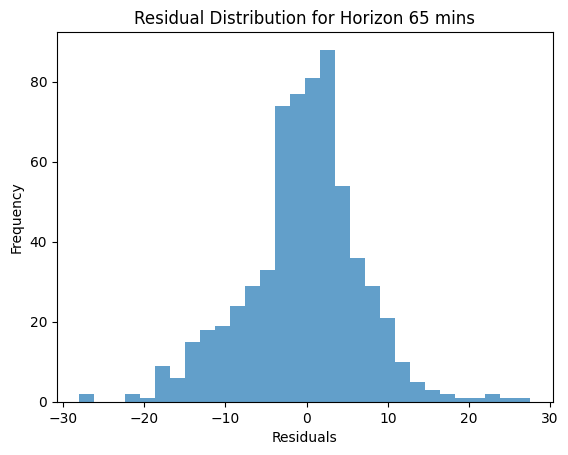

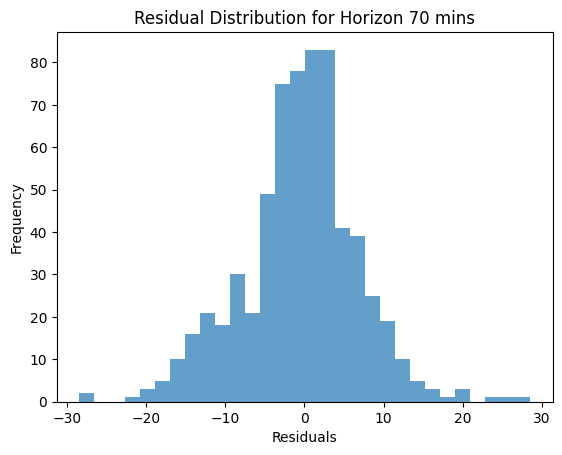

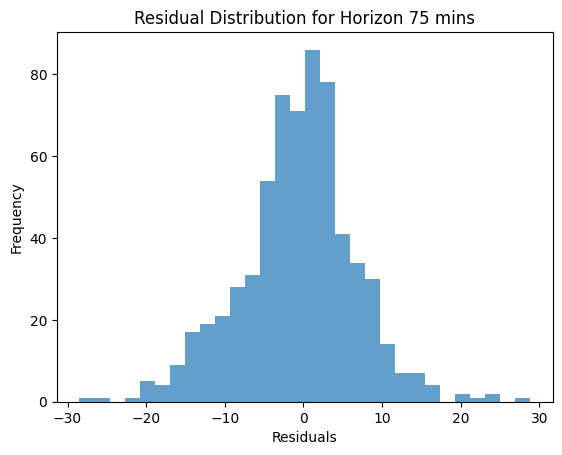

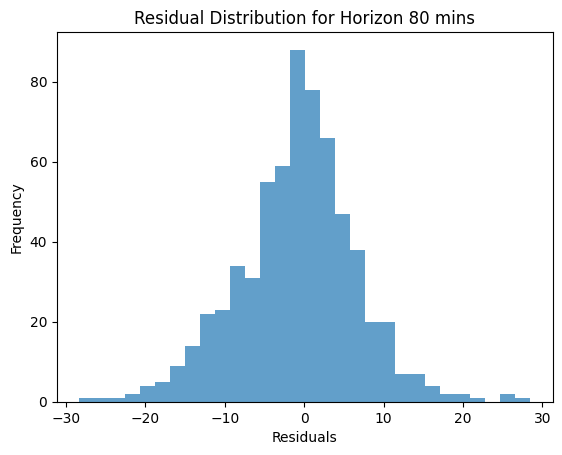

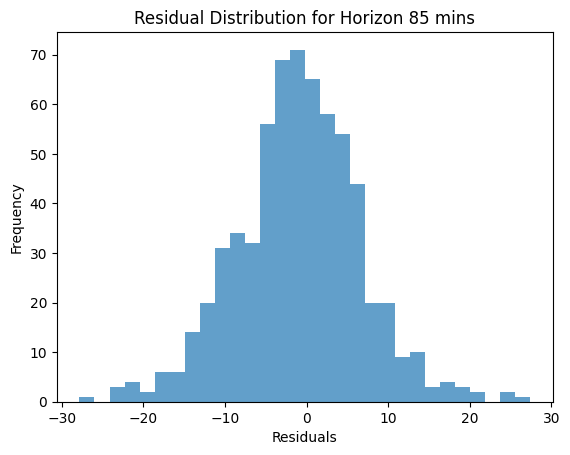

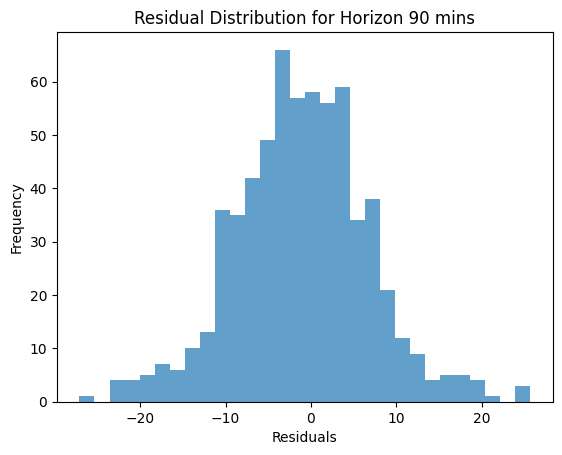

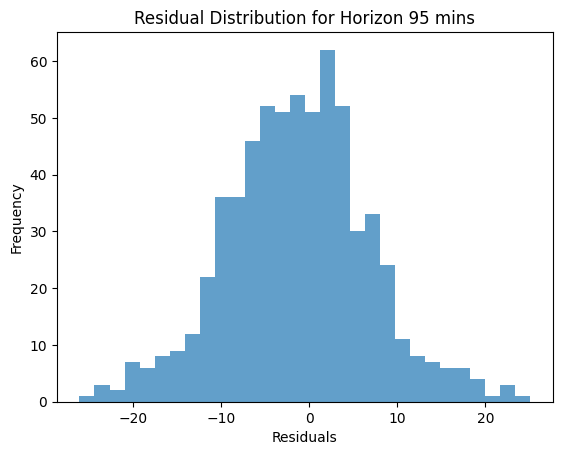

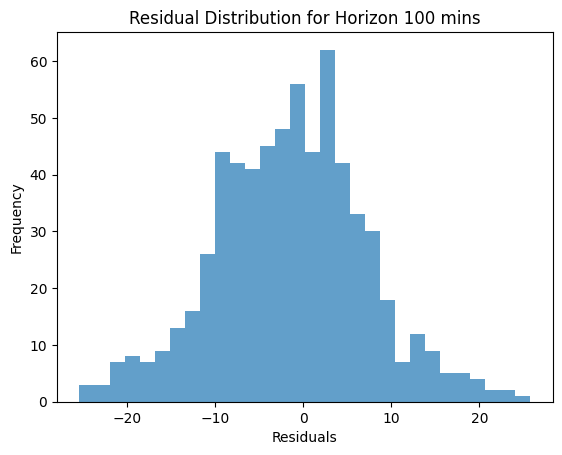

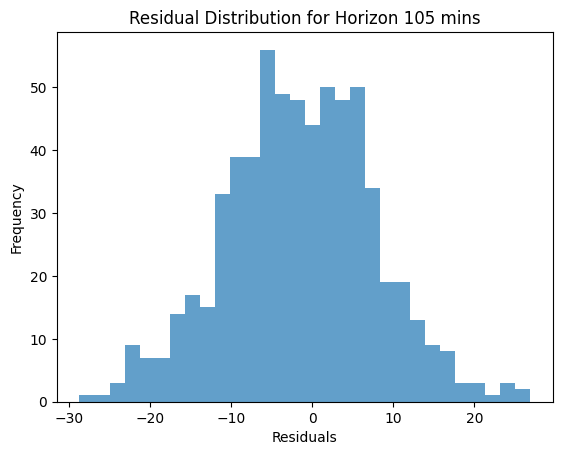

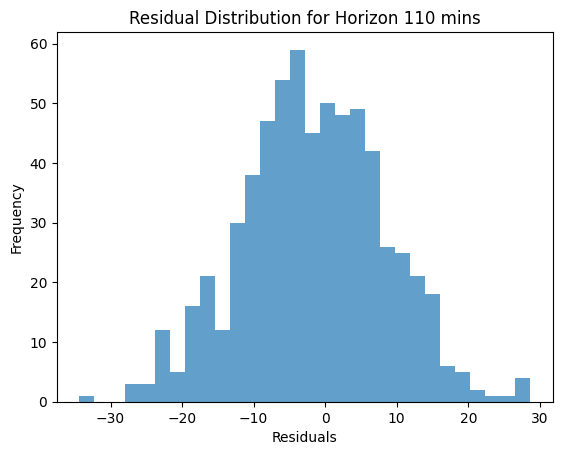

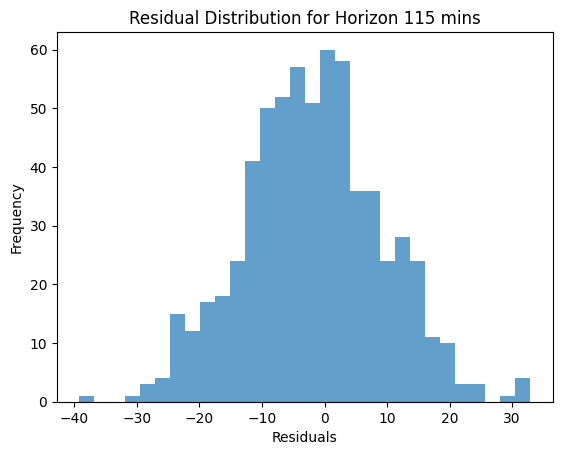

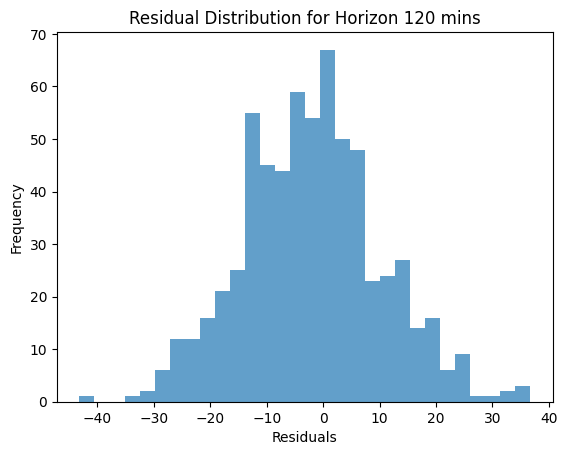

In [14]:
# Histogram of residuals

for i, h in enumerate(horizons):
    plt.figure()
    plt.hist(residuals_per_horizon[f"Horizon_{h}"], bins=30, alpha=0.7)
    plt.title(f'Residual Distribution for Horizon {h} mins')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

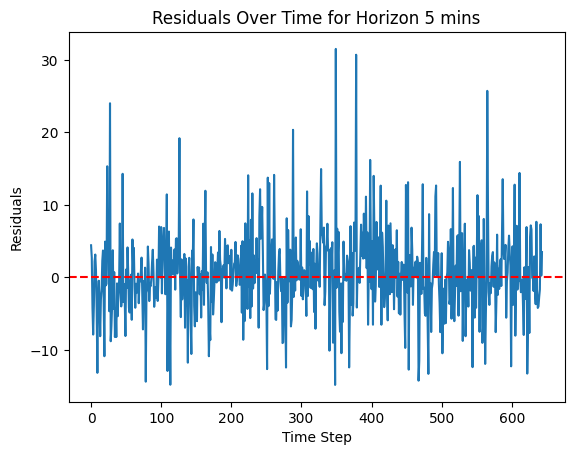

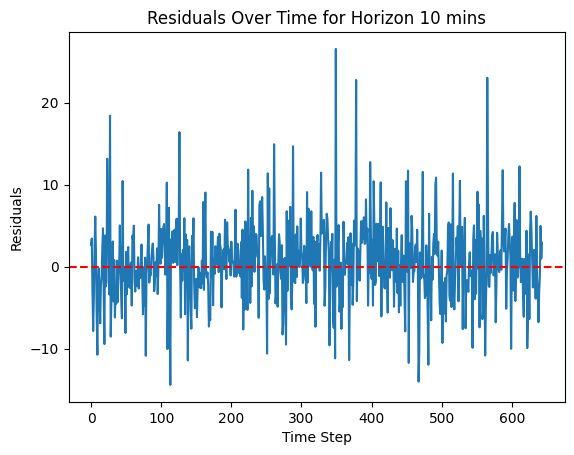

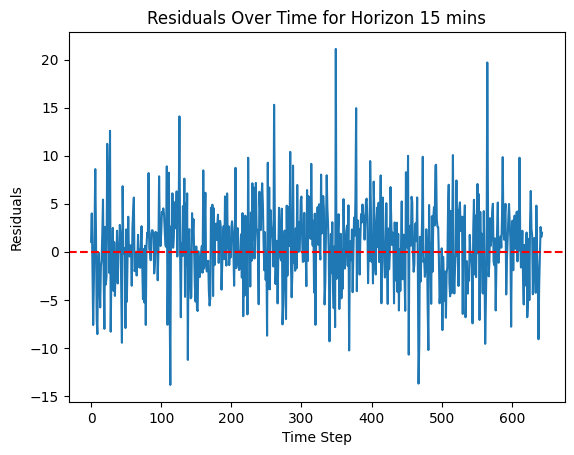

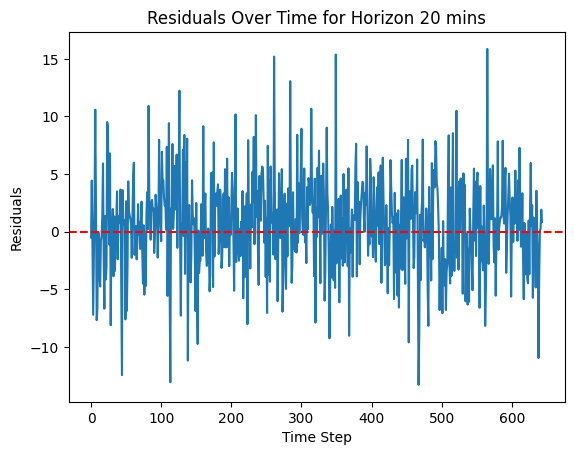

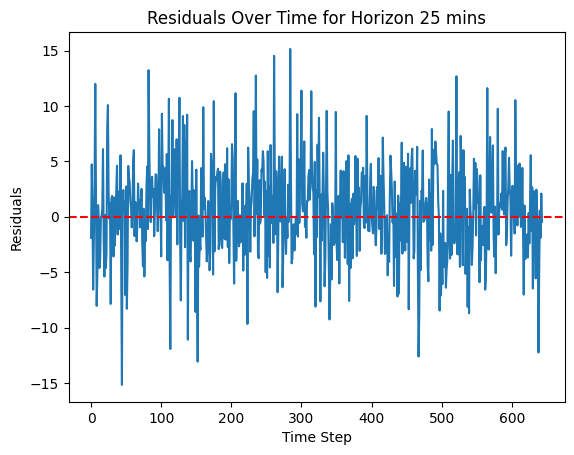

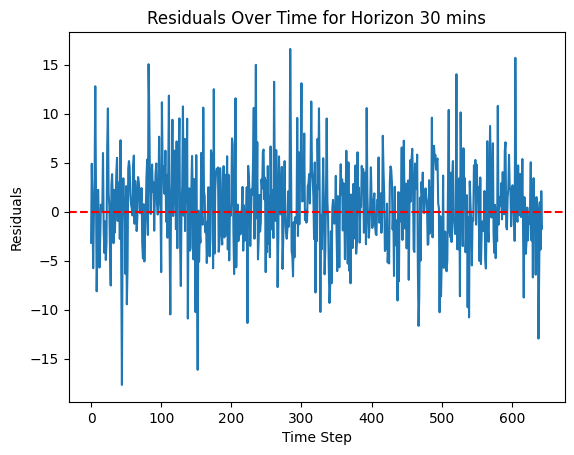

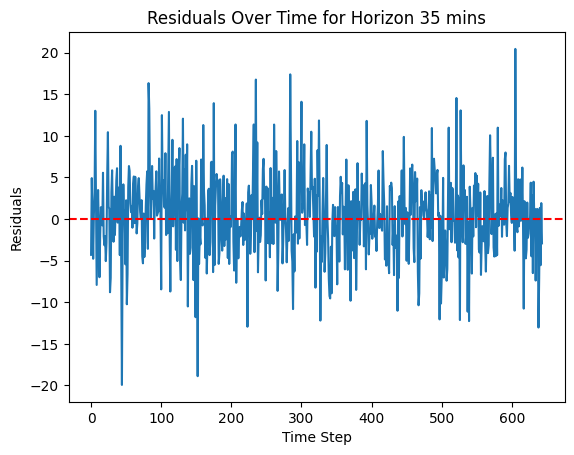

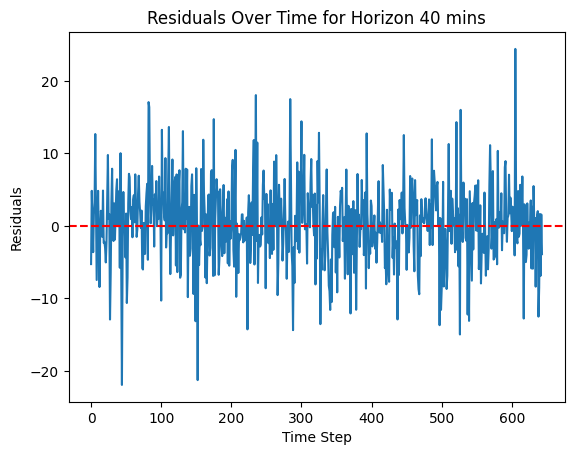

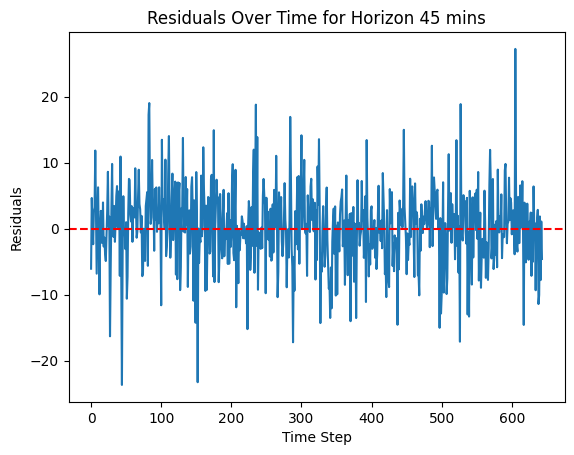

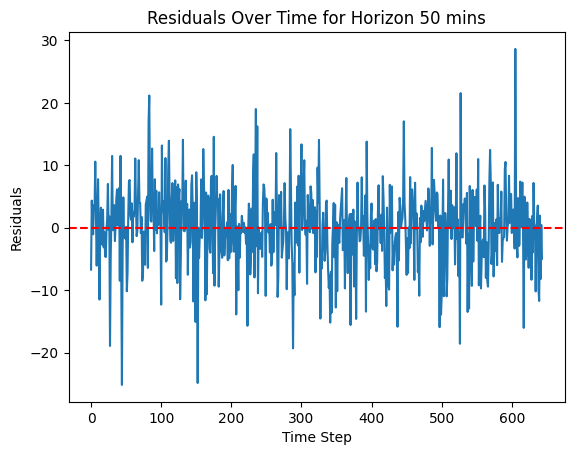

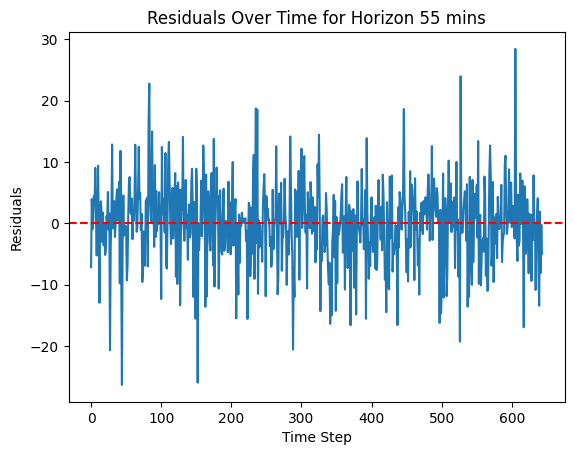

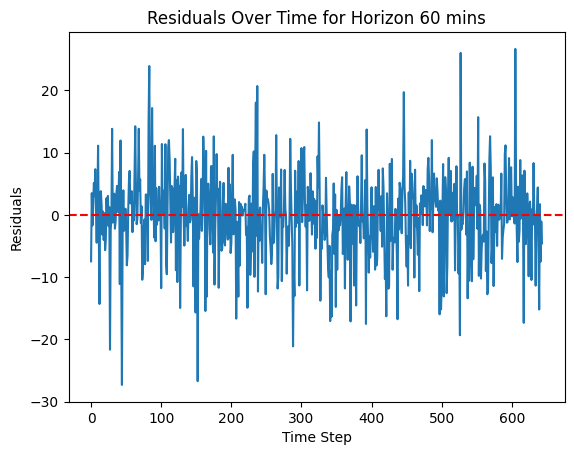

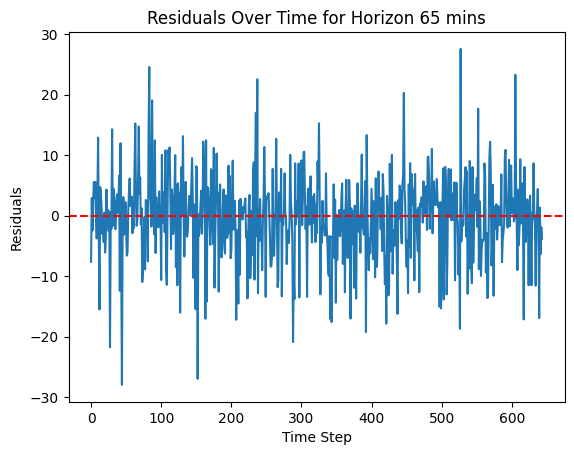

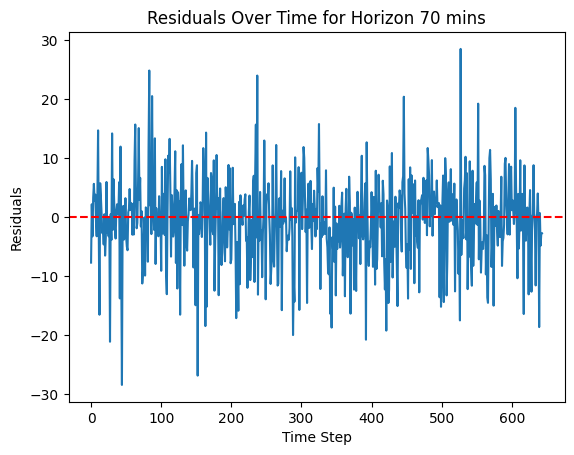

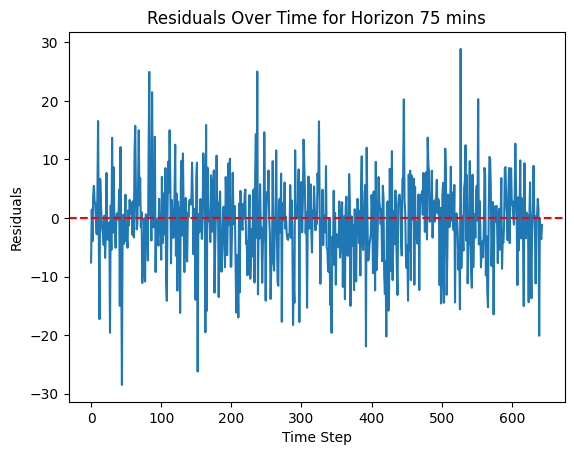

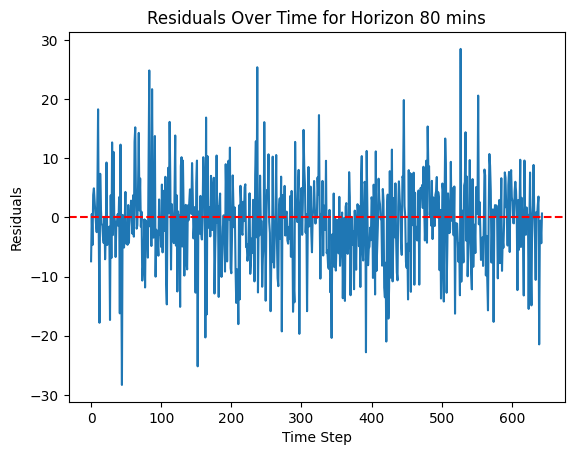

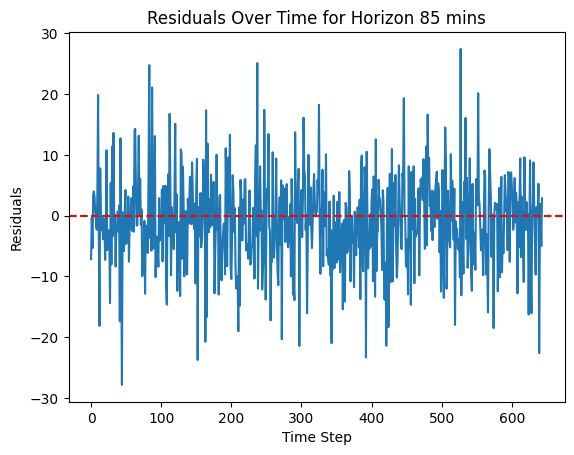

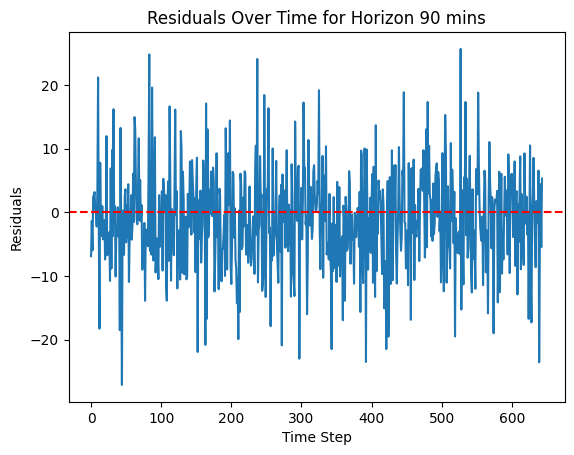

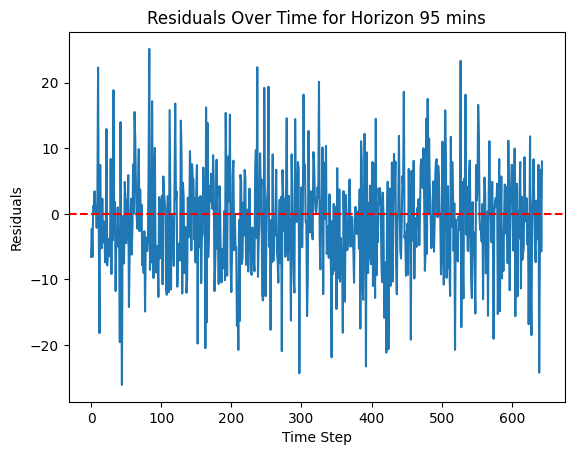

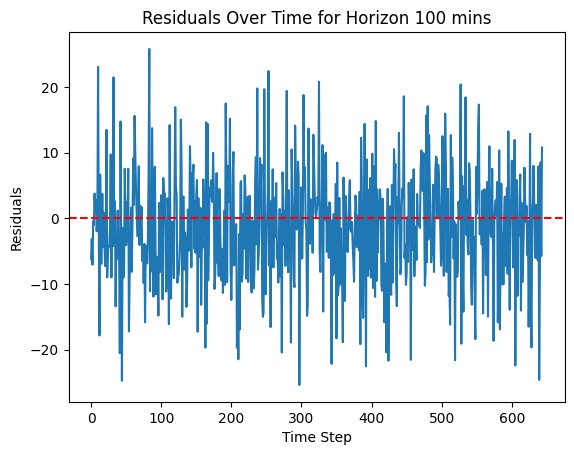

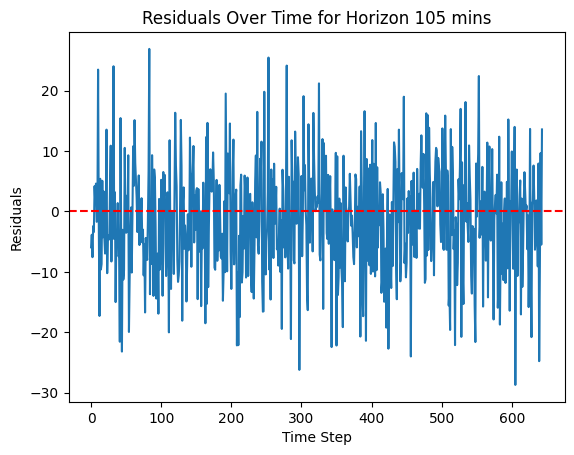

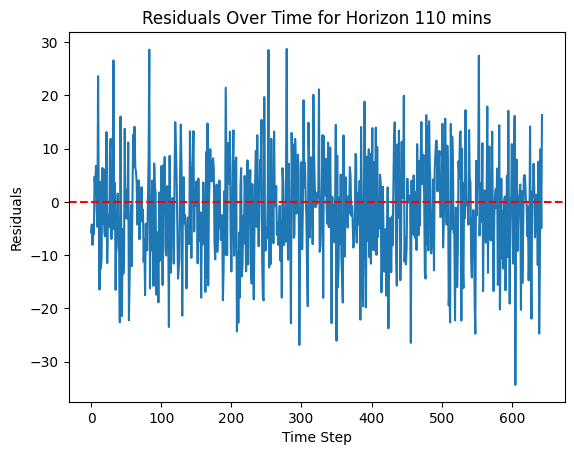

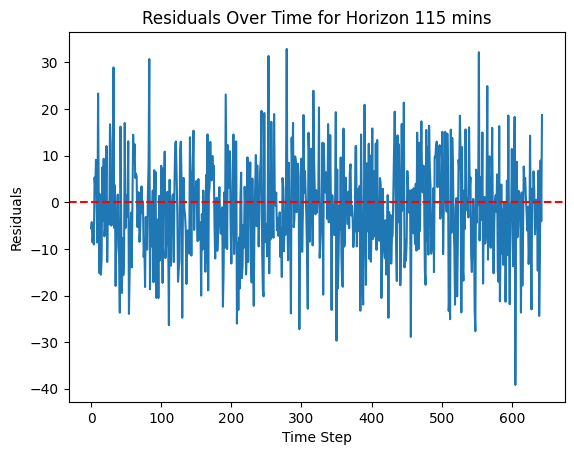

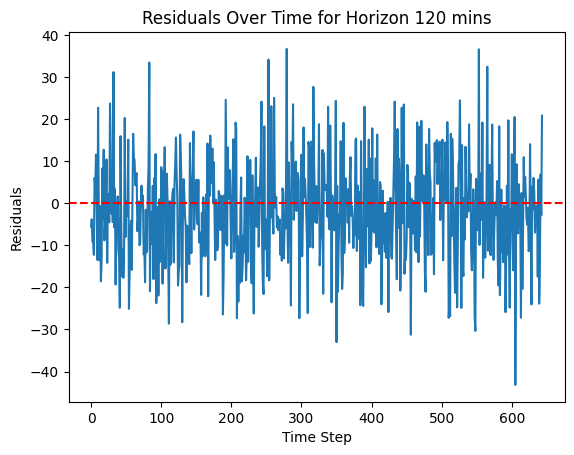

In [15]:
for i, h in enumerate(horizons):
    plt.figure()
    plt.plot(residuals_per_horizon[f"Horizon_{h}"])
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals Over Time for Horizon {h} mins')
    plt.xlabel('Time Step')
    plt.ylabel('Residuals')
    plt.show()

In [16]:
for h in horizons:
    res = residuals_per_horizon[f"Horizon_{h}"]
    print(f"Horizon {h} mins: Mean={np.mean(res):.2f}, Std={np.std(res):.2f}")


Horizon 5 mins: Mean=0.52, Std=5.81
Horizon 10 mins: Mean=0.58, Std=4.90
Horizon 15 mins: Mean=0.62, Std=4.34
Horizon 20 mins: Mean=0.64, Std=4.15
Horizon 25 mins: Mean=0.62, Std=4.29
Horizon 30 mins: Mean=0.57, Std=4.64
Horizon 35 mins: Mean=0.48, Std=5.09
Horizon 40 mins: Mean=0.37, Std=5.56
Horizon 45 mins: Mean=0.23, Std=6.00
Horizon 50 mins: Mean=0.07, Std=6.38
Horizon 55 mins: Mean=-0.09, Std=6.70
Horizon 60 mins: Mean=-0.26, Std=6.95
Horizon 65 mins: Mean=-0.42, Std=7.15
Horizon 70 mins: Mean=-0.58, Std=7.29
Horizon 75 mins: Mean=-0.73, Std=7.41
Horizon 80 mins: Mean=-0.88, Std=7.52
Horizon 85 mins: Mean=-1.02, Std=7.66
Horizon 90 mins: Mean=-1.15, Std=7.85
Horizon 95 mins: Mean=-1.29, Std=8.14
Horizon 100 mins: Mean=-1.42, Std=8.58
Horizon 105 mins: Mean=-1.55, Std=9.18
Horizon 110 mins: Mean=-1.68, Std=9.99
Horizon 115 mins: Mean=-1.81, Std=11.00
Horizon 120 mins: Mean=-1.95, Std=12.22
